In [180]:
# lib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd


In [181]:
# Define Encoder Architecture
class Sampling(Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# latent_dim is the dimensionality of the latent space.
latent_dim = 2

# Encoder Architecture
encoder_inputs = Input(shape=(28, 28, 1))  # Taille de nos images
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(120, activation="relu")(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder Architecture
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)  # Modifiez la taille ici
x = Reshape((7, 7, 64))(x)  # Modifiez la taille ici
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_44 (Conv2D)          (None, 14, 14, 32)           320       ['input_45[0][0]']            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 7, 7, 64)             18496     ['conv2d_44[0][0]']           
                                                                                                  
 flatten_22 (Flatten)        (None, 3136)                 0         ['conv2d_45[0][0]']           
                                                                                            

In [182]:
# VAE
class VAE(keras.Model):
    
    # Init method
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    # train step is the function that is called by fit() to train the model for one epoch
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)  
            reconstruction = self.decoder(z)  
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28 # dimension img
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [183]:
# Path_img
chemin_images = "images/images/"

# Csv file
chemin_csv = "pokemon.csv"
df = pd.read_csv(chemin_csv)

# Initialiser les listes pour les images et les labels
images = []
labels = []

# Create dataset
for index, row in df.iterrows():
    chemin_image = os.path.join(chemin_images, row['Name'])
    chemin_image = chemin_image + ".png"
    print(chemin_image)
    image = cv2.imread(chemin_image)

    # Vérification si l'image est None
    if image is None:
        print(f"Erreur de chargement pour l'image : {row['Name']}")
        continue  # Correction d'indentation ici

    # Convertir l'image en niveau de gris
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    images.append(image)
    labels.append(row['Type1'])


images_np = np.array(images)
labels_np = np.array(labels)

print(images_np.shape)
print(labels_np.shape)

images/images/bulbasaur.png
images/images/ivysaur.png
images/images/venusaur.png
images/images/charmander.png
images/images/charmeleon.png
images/images/charizard.png
images/images/squirtle.png
images/images/wartortle.png
images/images/blastoise.png
images/images/caterpie.png
images/images/metapod.png
images/images/butterfree.png
images/images/weedle.png
images/images/kakuna.png
images/images/beedrill.png
images/images/pidgey.png
images/images/pidgeotto.png
images/images/pidgeot.png
images/images/rattata.png
images/images/raticate.png
images/images/spearow.png
images/images/fearow.png
images/images/ekans.png
images/images/arbok.png
images/images/pikachu.png
images/images/raichu.png
images/images/sandshrew.png
images/images/sandslash.png
images/images/nidoran-f.png
images/images/nidorina.png
images/images/nidoqueen.png
images/images/nidoran-m.png
images/images/nidorino.png
images/images/nidoking.png
images/images/clefairy.png
images/images/clefable.png
images/images/vulpix.png
images/im

In [184]:
# load pokemon dataset
#x_train = images_np

# Expand dimension to add a color map dimension
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# load mnist digit dataset
(x_train, _), _ = keras.datasets.mnist.load_data()
print(x_train.shape)

# Expand dimension to add a color map dimension
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# compile and train the model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=100, batch_size=64)


(60000, 28, 28)
Epoch 1/100
938/938 [==============================] - 60s 60ms/step - loss: 182.6781 - reconstruction_loss: 179.8945 - kl_loss: 2.7835
Epoch 2/100
938/938 [==============================] - 54s 58ms/step - loss: 154.8305 - reconstruction_loss: 151.6036 - kl_loss: 3.2269
Epoch 3/100
938/938 [==============================] - 59s 63ms/step - loss: 149.9233 - reconstruction_loss: 146.4992 - kl_loss: 3.4241
Epoch 4/100
938/938 [==============================] - 59s 63ms/step - loss: 147.5365 - reconstruction_loss: 144.0299 - kl_loss: 3.5066
Epoch 5/100
938/938 [==============================] - 59s 63ms/step - loss: 146.1023 - reconstruction_loss: 142.5272 - kl_loss: 3.5751
Epoch 6/100
938/938 [==============================] - 59s 63ms/step - loss: 144.7954 - reconstruction_loss: 141.1742 - kl_loss: 3.6212
Epoch 7/100
938/938 [==============================] - 59s 63ms/step - loss: 143.8091 - reconstruction_loss: 140.1502 - kl_loss: 3.6589
Epoch 8/100
938/938 [===========

1/1 [==============================] - 0s 22ms/step


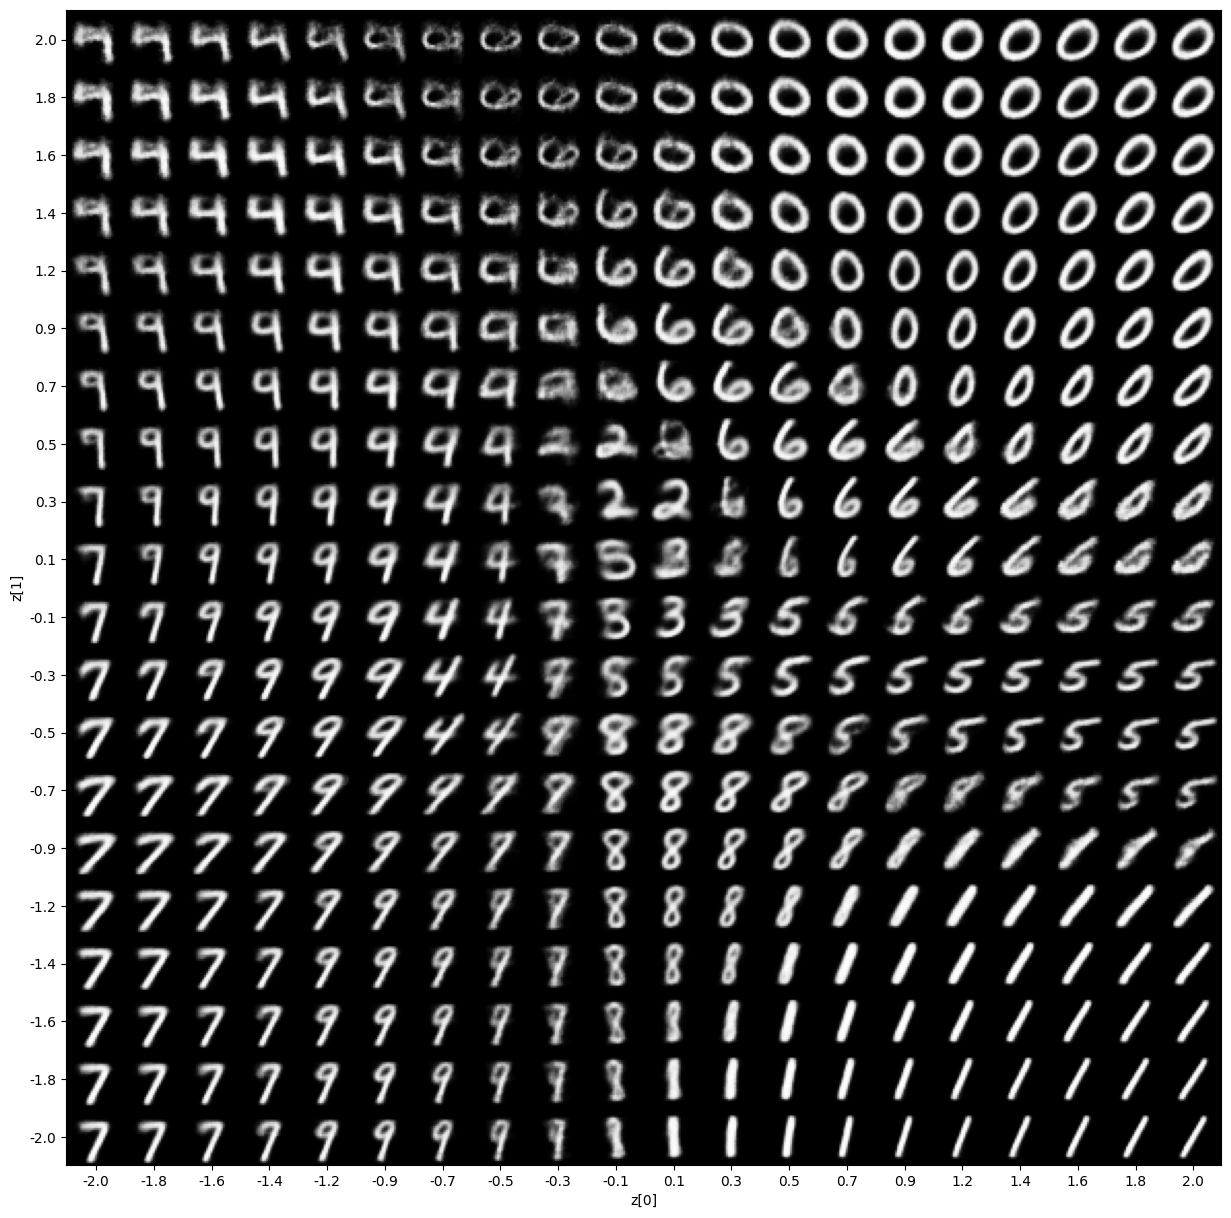

In [189]:
def plot_latent(encoder, decoder):
    # Display 10 img
    n = 20
    img_dim = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((img_dim * n, img_dim * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            images = x_decoded[0].reshape(img_dim, img_dim)
            figure[
            i * img_dim : (i + 1) * img_dim,
            j * img_dim : (j + 1) * img_dim,
            ] = images

    plt.figure(figsize =(figsize, figsize))
    start_range = img_dim // 2
    end_range = n * img_dim + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_dim)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    # Plot
    plt.xticks(pixel_range[:-1], sample_range_x)
    plt.yticks(pixel_range[:-1], sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap ="Greys_r")
    plt.show()


plot_latent(encoder, decoder)
